# Example 7: Bayesian optimization for model calibration

This notebook demonstrates how to perform Bayesian optimization (BO) for model calibration and parameter estimation using the `virus-mac-new` PhysiCell model. Bayesian optimization is a powerful technique for optimizing expensive black-box functions, making it ideal for calibrating computational models against experimental or observational data.

The calibration process uses a multi-objective approach to minimize the discrepancy between model predictions and observed data across multiple quantities of interest (QoIs). The method employs:

1. **Gaussian Process surrogate models**: To efficiently approximate the parameter-to-QoI mapping
2. **Acquisition functions**: To intelligently select new parameter combinations for evaluation
3. **Multi-objective optimization**: To simultaneously optimize multiple fitness criteria
4. **Pareto front analysis**: To identify trade-offs between competing objectives

The observational data represents the "ground truth" generated from a single simulation with known parameter values:
- **mac_phag_rate_infected**: 1.0 (rate at which macrophages phagocytose infected epithelial cells)
- **mac_motility_bias**: 0.15 (bias in macrophage motility towards chemotactic gradients)
- **epi2infected_sat**: 0.1 (saturation level for epithelial cell infection transition)
- **epi2infected_hfm**: 0.4 (half-maximum rate for epithelial cell infection transition)

The *in silico* observational data ([ex7_ObsData.csv](ex7_ObsData.csv)) was generated using [ex7_GenerateData.ipynb](ex7_GenerateData.ipynb). The goal is to recover these parameter values through the optimization process.

## Import modules and set up parameters

In [1]:
from uq_physicell.bo import CalibrationContext, SumSquaredDifferences, run_bayesian_optimization, analyze_pareto_results, plot_parameter_space, plot_qoi_param, plot_parameter_vs_fitness, get_observed_qoi
from uq_physicell.database.bo_db import load_structure

import matplotlib.pyplot as plt
# Real values for obs. data
dic_real_value = {'mac_phag_rate_infected': 1.0, 'mac_motility_bias': 0.15, 'epi2infected_sat': 0.1, 'epi2infected_hfm': 0.4}
# File name
db_path = "ex7_Calib_BO.db"
obs_data_path = "ex7_ObsData.csv"
# Model configuration (Reduced replicates for faster testing)
model_config = {
    "ini_path": "uq_pc_struc.ini", 
    "struc_name": "Model_struc", 
    "numReplicates": 5
}
# Quantities of Interest (QoI) functions
qoi_functions = {
    "epi_": "lambda df: len(df[df['cell_type'] == 'epithelial'])", 
    "epi_infected": "lambda df: len(df[df['cell_type'] == 'epithelial_infected'])"
}
# Mapping of QoI names to observed data columns
obs_data_columns = {
    'time': "Time", 
    "epi_": "Healthy Epithelial Cells", 
    "epi_infected": "Infected Epithelial Cells"
}
# Distance functions with weights for each QoI (Increased weights for better discrimination)
distance_functions = {
    "epi_": {"function": SumSquaredDifferences, "weight": 1e-5},
    "epi_infected": {"function": SumSquaredDifferences, "weight": 1e-5}
}
# Parameter search space with bounds
search_space = {
    "mac_phag_rate_infected": {"type": "real", "lower_bound": 0.7, "upper_bound": 1.5},
    "mac_motility_bias": {"type": "real", "lower_bound": 0.1, "upper_bound": 0.3},
    "epi2infected_sat": {"type": "real", "lower_bound": 0.05, "upper_bound": 0.2},
    "epi2infected_hfm": {"type": "real", "lower_bound": 0.1, "upper_bound": 0.5},
}
# Bayesian Optimization options (Optimized for better performance)
bo_options = {
    "num_initial_samples": 10,  # Increased for better initial coverage
    "num_iterations": 60,  # Good balance for thorough exploration  
    "max_workers": 10,  # Adjusted for optimal performance
    "use_exponential_fitness": True,  # Exponential scaling for better fitness scaling
}

## Create the context and run the Bayesian Optimization calibration

In [2]:
# Create the calibration context
calib_context = CalibrationContext(
    db_path=db_path,
    obsData=obs_data_path,
    obsData_columns=obs_data_columns,
    model_config=model_config,
    qoi_functions=qoi_functions,
    distance_functions=distance_functions,
    search_space=search_space,
    bo_options=bo_options,
)
# Run the Bayesian Optimization calibration
run_bayesian_optimization(calib_context)

2025-10-10 11:29:20,134 - INFO - 🔧 CalibrationContext initialized with 10 max workers, 5 inner workers, and 2 outer workers.
2025-10-10 11:29:20,134 - INFO - 🆕 Starting fresh optimization with database: ex7_Calib_BO.db
2025-10-10 11:29:20,138 - INFO - 🎲 Generating 10 initial samples...
2025-10-10 11:33:10,522 - INFO - 🔬 Detected multiple QoIs - using multi-objective Bayesian optimization loop.
2025-10-10 11:33:10,523 - INFO - ============================================================
2025-10-10 11:33:10,523 - INFO - 🔄 Multi-Objective BO Iteration 1/60
2025-10-10 11:33:10,524 - INFO - ============================================================
2025-10-10 11:33:10,524 - INFO - 🔧 Fitting Gaussian Process models...
2025-10-10 11:33:10,933 - INFO - 🎯 Optimizing acquisition function...
2025-10-10 11:33:11,391 - INFO - 📊 Evaluating 1 new candidate(s)...
2025-10-10 11:33:36,526 - INFO - 📊 Iteration 1 Sample(s) [10] : Hypervolume = 0.833182638729945
2025-10-10 11:33:36,527 - INFO - ✅ Complet

In [3]:
# Load the database and perform analysis
df_metadata, df_param_space, df_qois, df_gp_models, df_samples, df_output = load_structure(db_path)
   

## Obtain the Pareto front point(s)

🔍 COMPREHENSIVE PARETO ANALYSIS

📊 Extracting all Pareto points ...
🎯 Current Pareto front size: 2

🎯 CURRENT PARETO FRONT:
   Number of Pareto optimal points: 2
   Sample IDs: [51, 58]

   📋 Pareto Front Details:
   Point 1 (Sample 51):
      Fitness: {'epi_': np.float64(0.9721279681631625), 'epi_infected': np.float64(0.9495412538163105)}
      Parameters: {'mac_phag_rate_infected': 1.5, 'mac_motility_bias': 0.14035863920419087, 'epi2infected_sat': 0.2, 'epi2infected_hfm': 0.4671567187512522}
   Point 2 (Sample 58):
      Fitness: {'epi_': np.float64(0.9855489699700032), 'epi_infected': np.float64(0.9491163125966837)}
      Parameters: {'mac_phag_rate_infected': 1.5, 'mac_motility_bias': 0.13147417018974403, 'epi2infected_sat': 0.1834085895630313, 'epi2infected_hfm': 0.475836257306372}


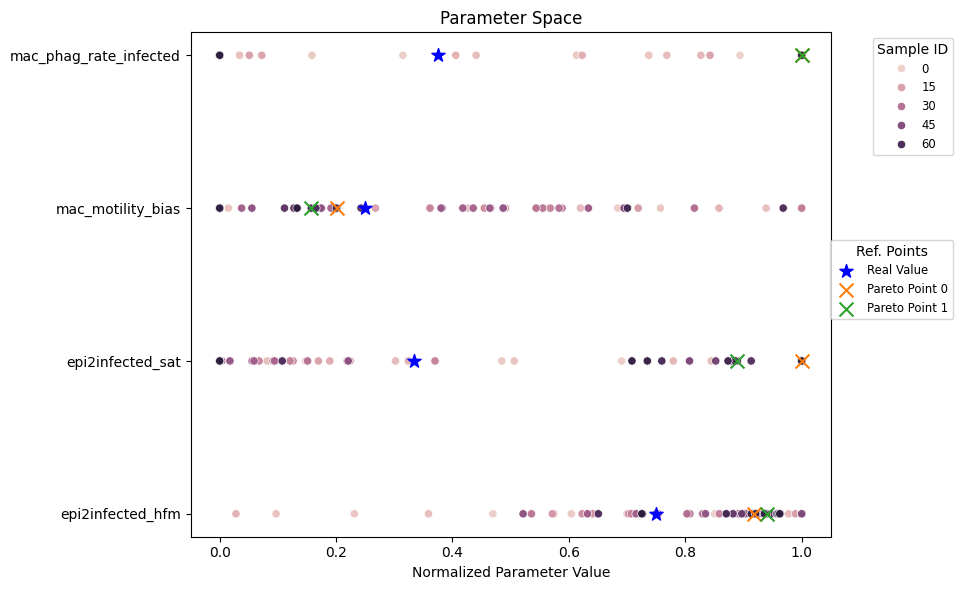

In [4]:
# Comprehensive Pareto analysis
pareto_data = analyze_pareto_results(df_qois, df_samples, df_output)
# Plot with pareto front points
pareto_points = {f"Pareto Point {i}": param for i, param in enumerate(pareto_data['pareto_front']['parameters'])}
plot_parameter_space(df_samples, df_param_space, params=pareto_points, real_value=dic_real_value)
df_obs_qoi = get_observed_qoi(df_metadata['ObsData_Path'].values[0], df_qois)


# Vizualize QoIs from Pareto front point(s)

Plotting epi_
Sample ID: [51, 58]
Objective Function Values:
{'epi_': np.float64(0.9721279681631625), 'epi_infected': np.float64(0.9495412538163105)}
Noise of Objective Function:
{'epi_': np.float64(0.0299238147456124), 'epi_infected': np.float64(0.05938026226497662)}
Plotting epi_infected
Sample ID: [51, 58]
Objective Function Values:
{'epi_': np.float64(0.9721279681631625), 'epi_infected': np.float64(0.9495412538163105)}
Noise of Objective Function:
{'epi_': np.float64(0.0299238147456124), 'epi_infected': np.float64(0.05938026226497662)}


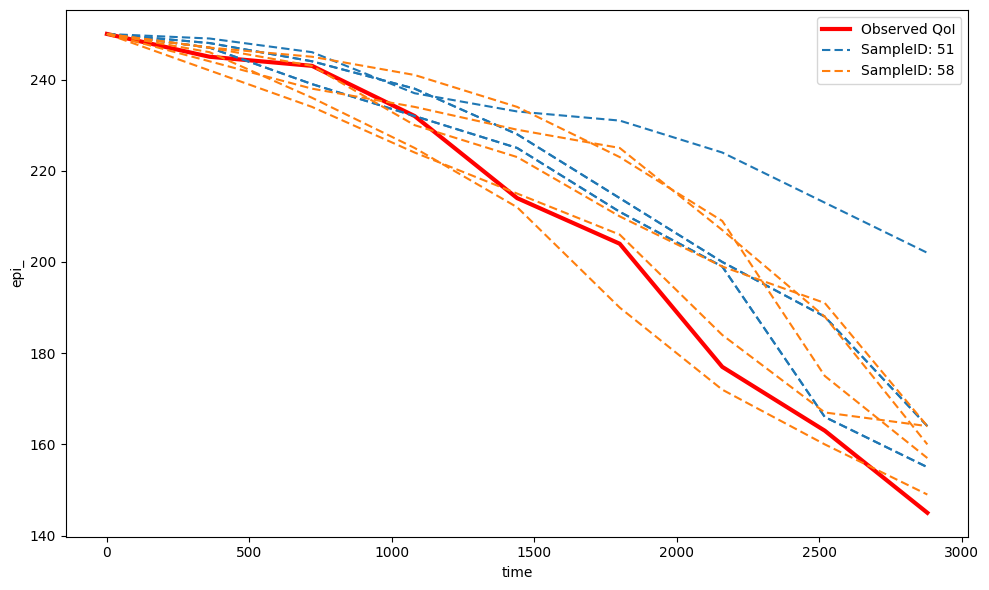

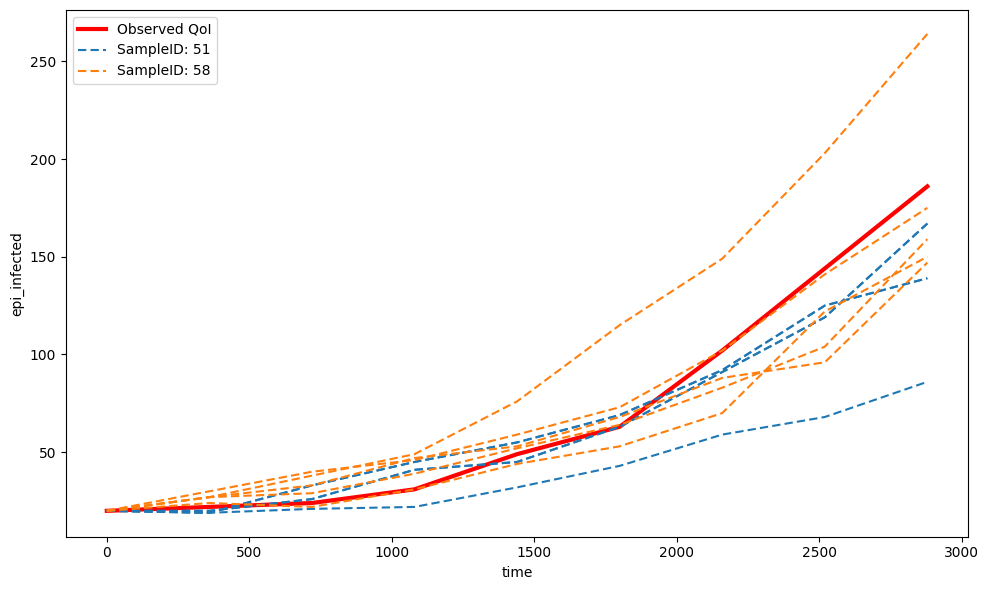

In [5]:
# Plot QoIs of best parameters
for qoi in df_qois['QoI_Name']:
    print(f"Plotting {qoi}")
    plot_qoi_param(df_obs_qoi, df_output, pareto_data['pareto_front']['sample_ids'], x_var='time', y_var=qoi)

## Vizualize the QoIs fitness vs Parameters values

Plotting mac_phag_rate_infected vs epi_
Plotting mac_phag_rate_infected vs epi_infected
Plotting mac_motility_bias vs epi_
Plotting mac_motility_bias vs epi_infected
Plotting epi2infected_sat vs epi_
Plotting epi2infected_sat vs epi_infected
Plotting epi2infected_hfm vs epi_
Plotting epi2infected_hfm vs epi_infected


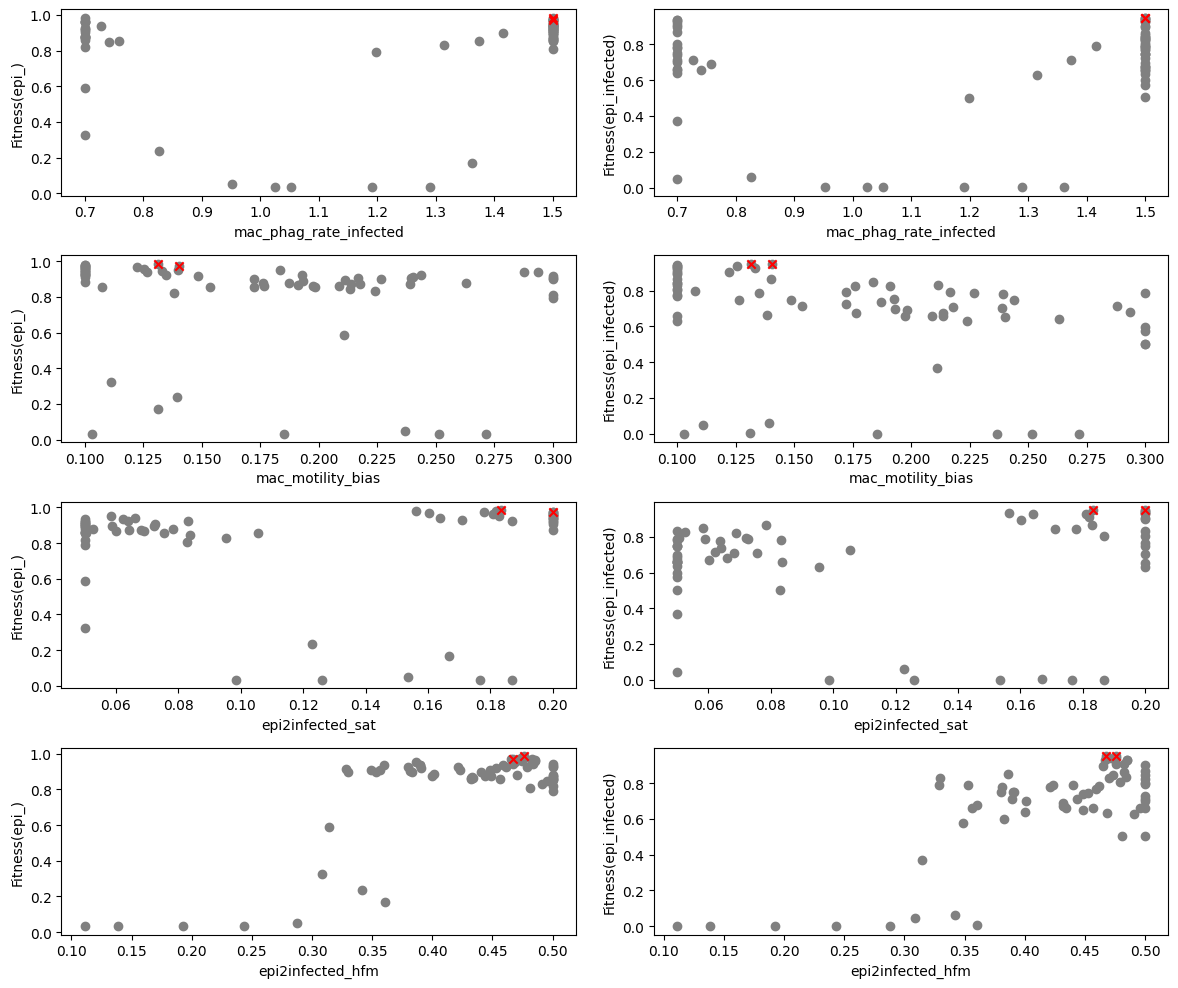

In [7]:
# Plot each parameter vs each QoI
fig, axes = plt.subplots(len(df_param_space), len(df_qois['QoI_Name']), figsize=(12, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Increased spacing
for i, param in enumerate(df_param_space['ParamName']):
    for j, qoi in enumerate(df_qois['QoI_Name']):
        print(f"Plotting {param} vs {qoi}")
        plot_parameter_vs_fitness(df_samples, df_output, param, qoi, samples_id=pareto_data['pareto_front']['sample_ids'], axis= axes[i, j])

# Ensure proper layout and save the figure
plt.tight_layout()  # This will automatically adjust spacing to prevent overlaps